1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6930
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


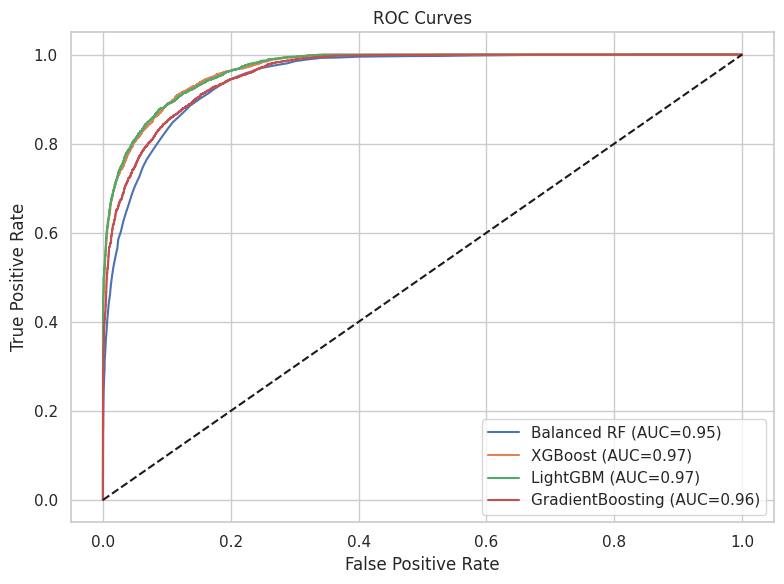

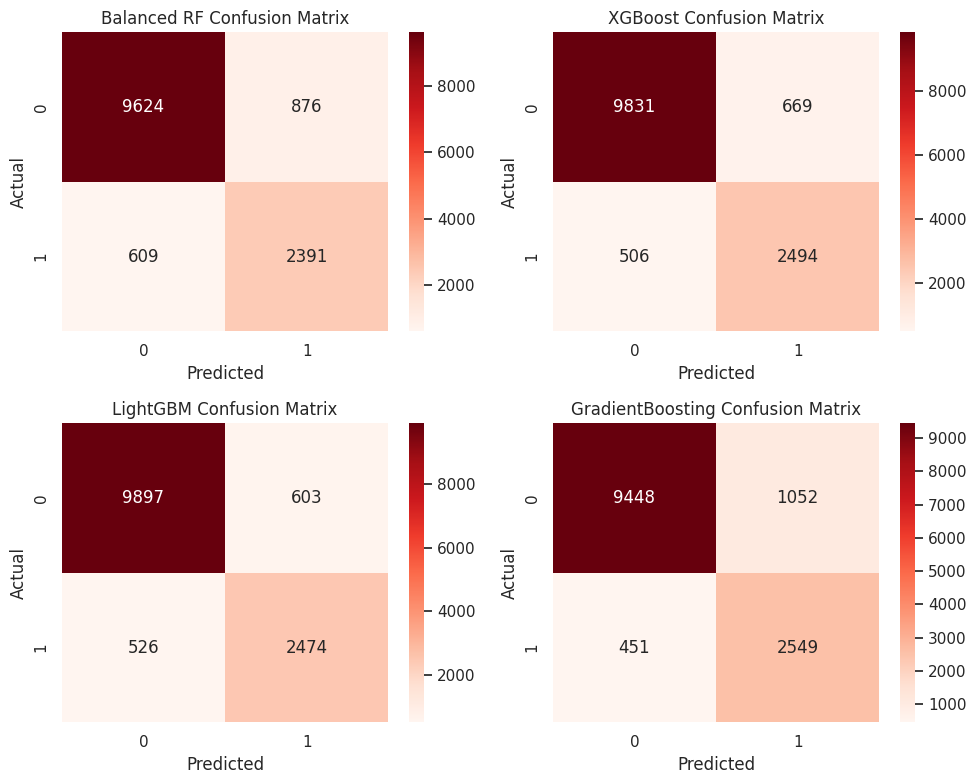

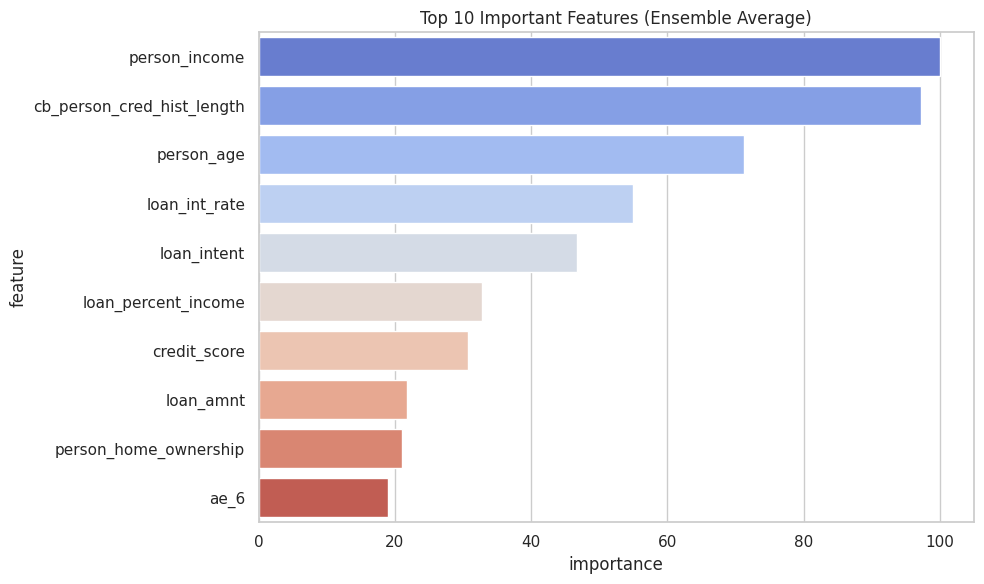

In [1]:
# Optimized MLCEFE Pipeline with Weighted Ensemble and Visualizations for Research Paper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers


def load_data():
    try_paths = [
        '/kaggle/input/loan-approval-classification-data/loan_data.csv'
    ]

    for path in try_paths:
        try:
            data = pd.read_csv(path)
            data.columns = [col.strip().lower().replace(' ', '_') for col in data.columns]
            possible_targets = ['loan_status', 'risk', 'default', 'y', 'target', 'approved']
            for target in possible_targets:
                if target in data.columns:
                    y = LabelEncoder().fit_transform(data[target])
                    X = data.drop(target, axis=1)
                    categorical_cols = X.select_dtypes(include=['object']).columns
                    for col in categorical_cols:
                        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
                    X = X.dropna(axis=1, how='all').fillna(X.mean())
                    return X, y
        except:
            continue
    return None, None


def pca_feature_extraction(X, n_components=0.95):
    X_scaled = StandardScaler().fit_transform(X)
    X_pca = PCA(n_components=n_components).fit_transform(X_scaled)
    return X_pca


def autoencoder_feature_extraction(X, encoding_dim=10):
    input_layer = Input(shape=(X.shape[1],))
    encoded = Dense(encoding_dim * 2, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, verbose=0)
    return encoder.predict(X)


def train_ensemble(X_train, y_train):
    class_weights = len(y_train) / (2 * np.bincount(y_train))
    weight_dict = {0: class_weights[0], 1: class_weights[1]}

    classifiers = {
        'Balanced RF': BalancedRandomForestClassifier(
            n_estimators=100, random_state=42, sampling_strategy='all',
            replacement=True, bootstrap=False
        ),
        'XGBoost': XGBClassifier(scale_pos_weight=weight_dict[1]/weight_dict[0], use_label_encoder=False,
                                 eval_metric='logloss', random_state=42),
        'LightGBM': LGBMClassifier(class_weight=weight_dict, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42)
    }

    models = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        models[name] = clf
    return models


def evaluate_and_visualize(models, X_test, y_test, feature_names):
    sns.set(style="whitegrid")
    roc_data, confusion_matrices, importances, scores = [], {}, [], {}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)
        scores[name] = roc_auc
        confusion_matrices[name] = cm
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_data.append((name, fpr, tpr, roc_auc))
        if hasattr(model, 'feature_importances_'):
            importances.append(pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_,
                'model': name
            }))

    # Weighted ROC Curve
    plt.figure(figsize=(8, 6))
    for name, fpr, tpr, auc_score in roc_data:
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confusion Matrices
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    for ax, (name, cm) in zip(axes.flat, confusion_matrices.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax)
        ax.set_title(f"{name} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Feature Importance
    if importances:
        total_importance = pd.concat(importances)
        avg_importance = total_importance.groupby('feature')['importance'].mean().reset_index()
        top10 = avg_importance.nlargest(10, 'importance')
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=top10, palette='coolwarm')
        plt.title("Top 10 Important Features (Ensemble Average)")
        plt.tight_layout()
        plt.show()


def mlcefe_pipeline():
    X, y = load_data()
    if X is None:
        print("Data load failed.")
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_pca = pca_feature_extraction(X_train_scaled)
    X_test_pca = PCA(n_components=X_train_pca.shape[1]).fit(X_train_scaled).transform(X_test_scaled)

    X_train_ae = autoencoder_feature_extraction(X_train_scaled)
    X_test_ae = autoencoder_feature_extraction(X_test_scaled)

    X_train_comb = np.concatenate([X_train_scaled, X_train_pca, X_train_ae], axis=1)
    X_test_comb = np.concatenate([X_test_scaled, X_test_pca, X_test_ae], axis=1)

    feature_names = list(X.columns) + [f"pca_{i}" for i in range(X_train_pca.shape[1])] + [f"ae_{i}" for i in range(X_train_ae.shape[1])]
    models = train_ensemble(X_train_comb, y_train)
    evaluate_and_visualize(models, X_test_comb, y_test, feature_names)


if __name__ == '__main__':
    mlcefe_pipeline()


Running MLCEFE Pipeline on Kaggle Loan Approval Dataset
Available columns in dataset: ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
32358/32358 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
[LightGBM] [Info] Number of positive: 517726, number of negative: 517726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12813
[LightGBM] [Info] Number of data points in the train set: 1035452, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.5

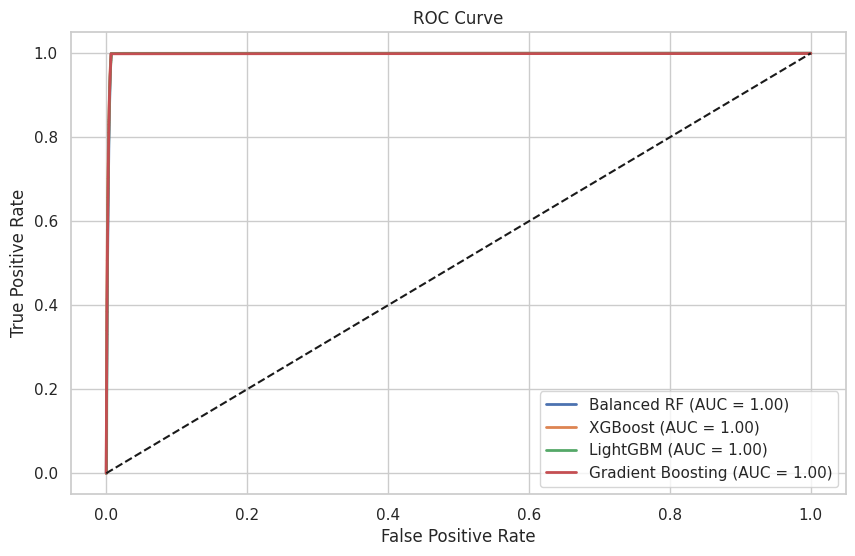

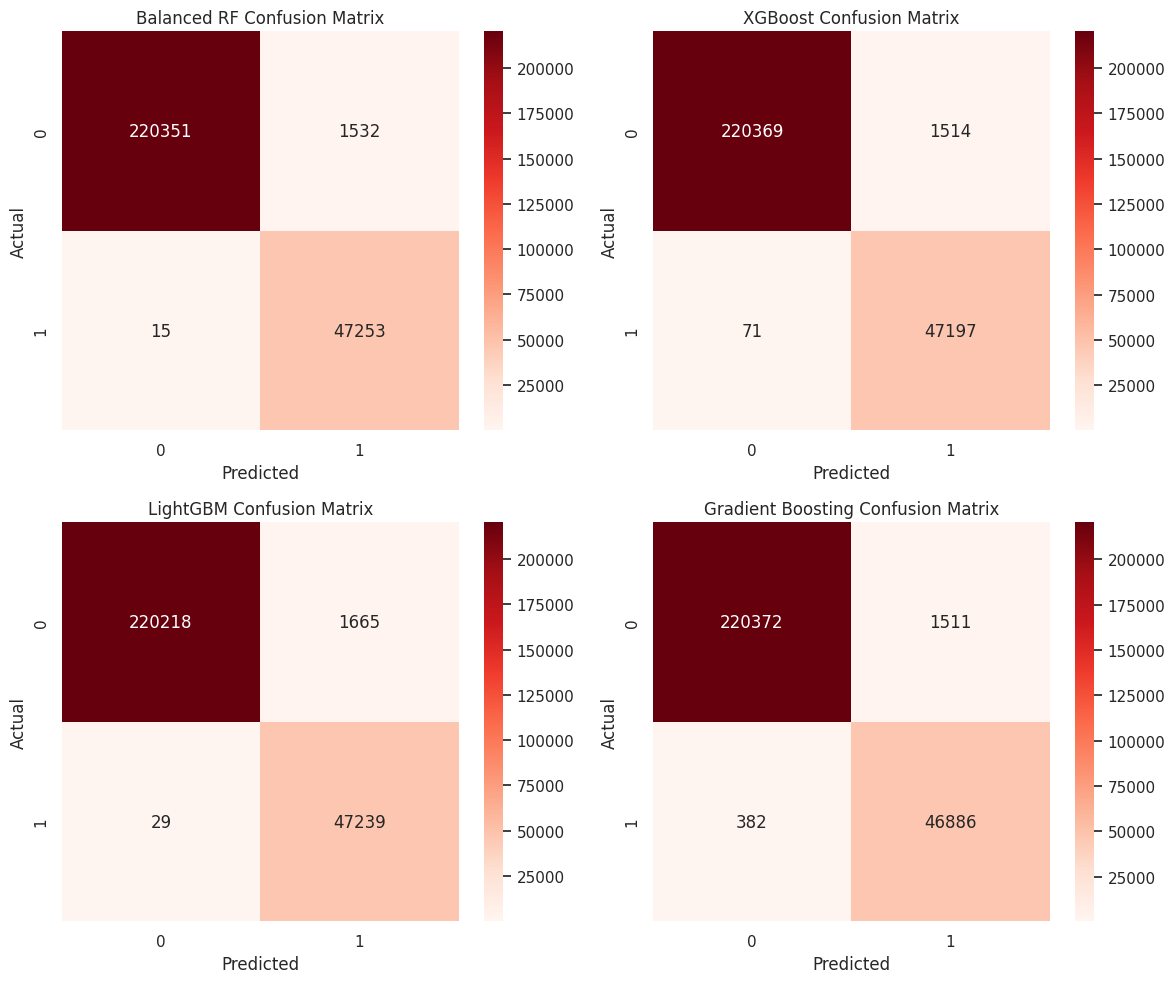

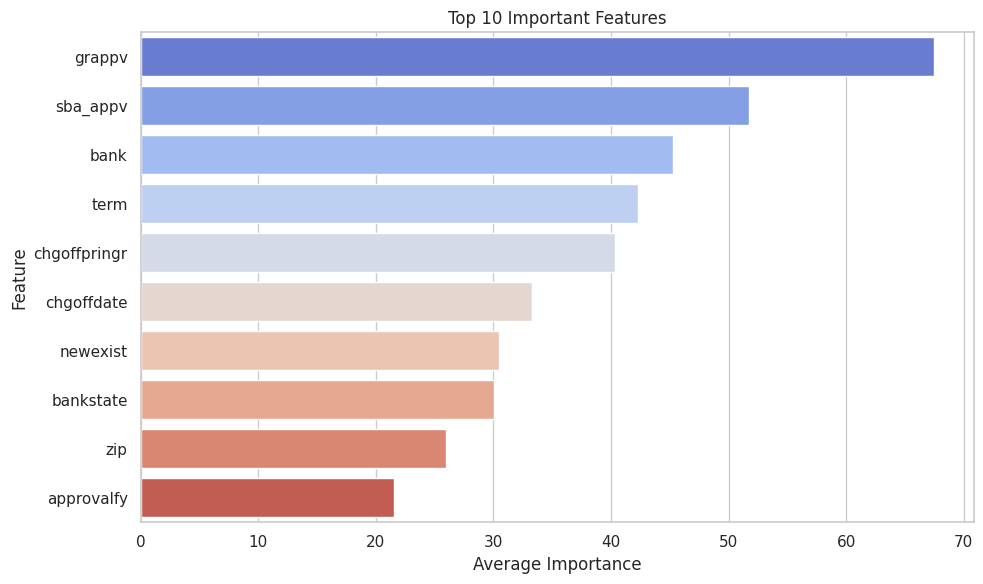

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

def load_data():
    path = '/kaggle/input/should-this-loan-be-approved-or-denied/SBAnational.csv'
    data = pd.read_csv(path)
    print("Available columns in dataset:", data.columns.tolist())
    data.columns = [col.strip().lower().replace(' ', '_') for col in data.columns]

    if 'mis_status' not in data.columns:
        raise ValueError("Target column 'mis_status' not found. Available columns are: {}".format(data.columns))

    target = 'mis_status'
    data = data.dropna(subset=[target])
    data[target] = data[target].apply(lambda x: 1 if x == 'CHGOFF' else 0)

    y = data[target]
    X = data.drop(target, axis=1)

    le = LabelEncoder()
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = le.fit_transform(X[col].astype(str))

    X = X.dropna(axis=1, how='all')
    X = X.fillna(X.mean())

    return X, y

def pca_feature_extraction(X, n_components=0.95):
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X_scaled), pca

def autoencoder_feature_extraction(X, encoding_dim=10):
    input_dim = X.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim*2, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(encoding_dim*2, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, verbose=0)
    return encoder.predict(X), encoder

def train_ensemble(X_train, y_train):
    class_counts = np.bincount(y_train)
    class_weights = len(y_train) / (2 * class_counts)
    weight_dict = {0: class_weights[0], 1: class_weights[1]}

    classifiers = {
        'Balanced RF': BalancedRandomForestClassifier(n_estimators=100, sampling_strategy='all', replacement=True, bootstrap=False, random_state=42),
        'XGBoost': XGBClassifier(scale_pos_weight=weight_dict[1]/weight_dict[0], use_label_encoder=False, eval_metric='logloss', random_state=42),
        'LightGBM': LGBMClassifier(class_weight=weight_dict, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    trained_models = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        trained_models[name] = clf

    return trained_models

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        report = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)
        results[name] = {
            'classification_report': report,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'y_prob': y_prob
        }
    return results

def analyze_feature_importance(models, feature_names):
    importance_df = pd.DataFrame()
    for name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            temp_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_,
                'model': name
            })
            importance_df = pd.concat([importance_df, temp_df])
    return importance_df

def visualize_results(results, importance_df, X_test_combined, y_test):
    sns.set(style="whitegrid")

    # ROC Curve
    plt.figure(figsize=(10, 6))
    for name, res in results.items():
        fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {res["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    for i, (name, res) in enumerate(results.items()):
        sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Reds', ax=axs[i])
        axs[i].set_title(f'{name} Confusion Matrix')
        axs[i].set_xlabel('Predicted')
        axs[i].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Feature Importance
    if not importance_df.empty:
        top_features = importance_df.groupby('feature')['importance'].mean().nlargest(10).reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=top_features, palette='coolwarm')
        plt.title('Top 10 Important Features')
        plt.xlabel('Average Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

def mlcefe_pipeline():
    print("Running MLCEFE Pipeline on Kaggle Loan Approval Dataset")
    X, y = load_data()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Feature extraction
    X_pca, pca = pca_feature_extraction(X_train_res)
    X_test_pca = pca.transform(StandardScaler().fit_transform(X_test))

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    X_ae, encoder = autoencoder_feature_extraction(X_train_scaled)
    X_test_ae = encoder.predict(X_test_scaled)

    # Combine features
    X_train_comb = np.concatenate([X_train_res, X_pca, X_ae], axis=1)
    X_test_comb = np.concatenate([X_test, X_test_pca, X_test_ae], axis=1)

    models = train_ensemble(X_train_comb, y_train_res)
    results = evaluate_models(models, X_test_comb, y_test)

    feature_names = list(X.columns) + [f'pca_{i}' for i in range(X_pca.shape[1])] + [f'ae_{i}' for i in range(X_ae.shape[1])]
    importance_df = analyze_feature_importance(models, feature_names)

    visualize_results(results, importance_df, X_test_comb, y_test)

if __name__ == '__main__':
    mlcefe_pipeline()